In [1]:
!pip install pandas numpy scikit-learn tensorflow kaggle matplotlib seaborn

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.4 MB 255.0 kB/s eta 0:00:04
   --------------- ------------------------ 0.5/1.4 MB 255.0 kB/s eta 0:00:04
   ----------------------- ---------------- 0.8/1.4 MB 325.5 kB/s eta 0:00:02
   ----------------------- ---------------- 0.8/1.4 MB 325.5 kB/s eta 0:00:0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.preprocessing import StandardScaler


In [86]:
df = pd.read_csv("Car_dataset.csv")
df.head()


,ID,Price,Levy,Manufacturer,Model,year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear type,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6,Automatic,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6,Tiptronic,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4,Variator,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4,Automatic,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4,Automatic,Left wheel,Silver,4


In [87]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                19237 non-null  int64 
 1   Price             19237 non-null  int64 
 2   Levy              19237 non-null  object
 3   Manufacturer      19237 non-null  object
 4   Model             19237 non-null  object
 5   year              19237 non-null  int64 
 6   Category          19237 non-null  object
 7   Leather interior  19237 non-null  object
 8   Fuel type         19237 non-null  object
 9   Engine volume     19237 non-null  object
 10  Mileage           19237 non-null  object
 11  Cylinders         19237 non-null  int64 
 12  Gear type         19237 non-null  object
 13  Wheel             19237 non-null  object
 14  Color             19237 non-null  object
 15  Airbags           19237 non-null  int64 
dtypes: int64(5), object(11)
memory usage: 2.3+ MB


ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
year                0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear type           0
Wheel               0
Color               0
Airbags             0
dtype: int64

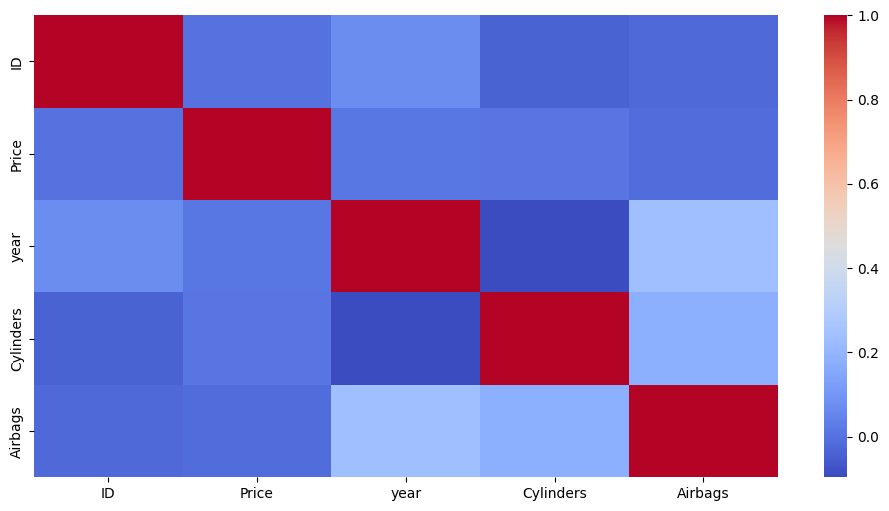

In [88]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.show()


In [89]:
df = df.drop("ID", axis=1)


In [90]:
# Levy
df["Levy"] = pd.to_numeric(df["Levy"].replace(["—", "-"], "0"),
                           errors="coerce").fillna(0).astype(int)

# Extract Turbo BEFORE removing the word
df["Turbo"] = df["Engine volume"].str.contains("Turbo").astype(int)

# Clean engine volume
df["Engine volume"] = df["Engine volume"].str.replace(" Turbo", "", regex=False).astype(float)

# Clean mileage
df["Mileage"] = df["Mileage"].str.replace(" km", "", regex=False).astype(int)

# Leather interior to binary
df["Leather interior"] = df["Leather interior"].map({"Yes":1, "No":0})


In [91]:
# --------------------------
# 3. REMOVE OUTLIERS + LOG PRICE
# --------------------------
df = df[df["Price"] < 200_000]
df["Price"] = np.log1p(df["Price"])


# --------------------------
# 4. REDUCE HIGH-CARDINALITY CATEGORIES
# --------------------------
top_models = df["Model"].value_counts().head(20).index
df = df[df["Model"].isin(top_models)]

top_makers = df["Manufacturer"].value_counts().head(20).index
df = df[df["Manufacturer"].isin(top_makers)]


In [92]:
# --------------------------
# 5. ONE HOT ENCODE
# --------------------------
X = df.drop("Price", axis=1)
y = df["Price"]

X = pd.get_dummies(X, drop_first=True)

print("Features:", X.shape)
print("Target:", y.shape)

Features: (9177, 70)
Target: (9177,)


In [93]:
# --------------------------
# 6. SCALE NUMERIC COLUMNS
# --------------------------
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [94]:
# --------------------------
# 7. TRAIN TEST SPLIT
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

(7341, 70) (1836, 70)


In [115]:
# --------------------------
# 8. BUILD MODEL
# --------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6
)

model = models.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(X_train.shape[1],)),
    layers.Dropout(0.25),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(32, activation='relu'),

    layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mae', metrics=['mse'])

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=150,
    batch_size=64,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

Epoch 1/150


C:\Users\NlpLap.lk\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.7384 - mse: 13.6224 - val_loss: 1.5041 - val_mse: 2.2415 - learning_rate: 0.0010
Epoch 2/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4330 - mse: 3.1020 - val_loss: 1.1080 - val_mse: 1.7294 - learning_rate: 0.0010
Epoch 3/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3191 - mse: 2.4518 - val_loss: 1.0840 - val_mse: 1.5794 - learning_rate: 0.0010
Epoch 4/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2682 - mse: 2.2282 - val_loss: 1.2079 - val_mse: 1.6910 - learning_rate: 0.0010
Epoch 5/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2164 - mse: 2.0859 - val_loss: 0.9951 - val_mse: 1.5234 - learning_rate: 0.0010
Epoch 6/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1782 - mse: 1.9870 - val_loss: 1.2649 - val_mse: 1.8792 - learning_rate: 0.0010
Epoch 7/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1456 - mse: 1.9383 - val_loss: 1.1486 - val_mse: 1.6452 - learning_rate: 0.0010
Epoch 8/15

In [116]:
# --------------------------
# 9. EVALUATION
# --------------------------
y_pred = model.predict(X_test).flatten()

y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, y_pred_real)

print("Real MSE:", mse)
print("Real RMSE:", rmse)
print("Real R2:", r2)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Real MSE: 86232819.22495258
Real RMSE: 9286.162782600388
Real R2: 0.6486927698645143


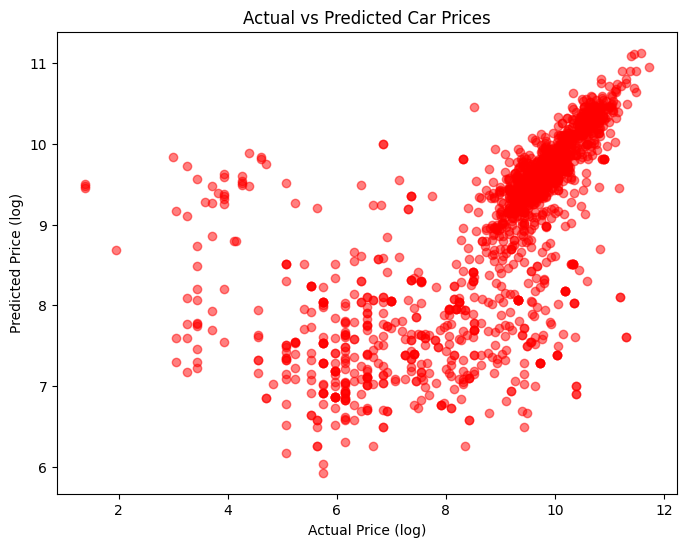

In [114]:
# --------------------------
# 10. PLOT
# --------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='r', alpha=0.5)
plt.xlabel("Actual Price (log)")
plt.ylabel("Predicted Price (log)")
plt.title("Actual vs Predicted Car Prices")
plt.show()